In [1]:
from citylearn import  CityLearn, building_loader, auto_size
from energy_models import HeatPump, EnergyStorage, Building
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
np.random.seed(1)

Unmark only one building ID for SINGLE AGENT environment, unmark multiple building IDs to simulate MULTI-AGENT environment. In the multi-agent environment
the reward of each agent depend partially on the actions of the other agents or buildings (see reward_function.py). The RL agent in agent.py can run for multiple agents, but it is not designed to coordinate multiple buildings properly or share information among them. To coordinate multiple buildings, please modify the agent such that they can share information among each other as decentralized agents or as a central agent that controls all the buildings.
The states are: hour of day (s1), outdoor temperature (s2), state of the charge of the energy storage device (s3). s1 and s2 are the same for all the buildings/agents, while s3 is different for each building.
Objective: coordinate multiple buildings such that they reduce the overall cost of electricity by consuming less energy and avoiding consuming it simultaneously.
When all the buildings consume electricity simultaneously, the price of electricity raises (see reward_function.py) and they all pay more for consuming it.
This main file originally contains the implementation of a DDPG RL agent to control a single building/agent.

In [ ]:
#Use only one building for SINGLE AGENT environment, unmark multiple building IDs to simulate MULTI-AGENT environment. In the multi-agent environment
#the reward of each agent depend partially on the actions of the other agents or buildings (see reward_function.py)
building_ids = [4]#, 5, 9, 16, 21, 26, 33, 36, 49, 59]

In [2]:
#Building the RL environment with heating and cooling loads and weather files
'''
CityLearn
    Weather file
    Buildings
        File with heating and cooling demands
        CoolingDevices (HeatPump)
        CoolingStorages (EnergyStorage)
'''

data_folder = Path("data/")

demand_file = data_folder / "AustinResidential_TH.csv"
weather_file = data_folder / 'Austin_Airp_TX-hour.csv'

heat_pump, heat_tank, cooling_tank = {}, {}, {}

#Ref: Assessment of energy efficiency in electric storage water heaters (2008 Energy and Buildings)
loss_factor = 0.19/24
buildings = []
for uid in building_ids:
    heat_pump[uid] = HeatPump(nominal_power = 9e12, eta_tech = 0.22, t_target_heating = 45, t_target_cooling = 10)
    heat_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    cooling_tank[uid] = EnergyStorage(capacity = 9e12, loss_coeff = loss_factor)
    buildings.append(Building(uid, heating_storage = heat_tank[uid], cooling_storage = cooling_tank[uid], heating_device = heat_pump[uid], cooling_device = heat_pump[uid]))
    buildings[-1].state_space(np.array([24.0, 40.0, 1.001]), np.array([1.0, 17.0, -0.001]))
    buildings[-1].action_space(np.array([0.5]), np.array([-0.5]))
    
building_loader(demand_file, weather_file, buildings)  
auto_size(buildings, t_target_heating = 45, t_target_cooling = 10)

env = CityLearn(demand_file, weather_file, buildings = buildings, time_resolution = 1, simulation_period = (3500,6000))

In [3]:
from reward_function import reward_function
from agent import RL_Agents

#Extracting the state-action spaces from the buildings to feed them to the agent(s)
observations_space, actions_space = [],[]
for building in buildings:
    observations_space.append(building.observation_spaces)
    actions_space.append(building.action_spaces)

agents = RL_Agents(observations_space,actions_space)
episodes = 3
k = 0
score = {}
for e in range(episodes):
    score[e] = 0
    state = env.reset()
    done = False
    while not done:
        if k%200==0:
            print('hour: '+str(k)+' of '+str(2500*episodes))
        action = agents.select_action(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward_function(reward)
        agents.add_to_batch(state, action, reward, next_state)
        state = next_state
        score[e] += reward[0]
        k+=1

hour: 0 of 7500
hour: 200 of 7500
hour: 400 of 7500
hour: 600 of 7500
hour: 800 of 7500
hour: 1000 of 7500
hour: 1200 of 7500
hour: 1400 of 7500
hour: 1600 of 7500
hour: 1800 of 7500
hour: 2000 of 7500
hour: 2200 of 7500
hour: 2400 of 7500
hour: 2600 of 7500
hour: 2800 of 7500
hour: 3000 of 7500
hour: 3200 of 7500
hour: 3400 of 7500
hour: 3600 of 7500
hour: 3800 of 7500
hour: 4000 of 7500
hour: 4200 of 7500
hour: 4400 of 7500
hour: 4600 of 7500
hour: 4800 of 7500
hour: 5000 of 7500
hour: 5200 of 7500
hour: 5400 of 7500
hour: 5600 of 7500
hour: 5800 of 7500
hour: 6000 of 7500
hour: 6200 of 7500
hour: 6400 of 7500
hour: 6600 of 7500
hour: 6800 of 7500
hour: 7000 of 7500
hour: 7200 of 7500
hour: 7400 of 7500


In [4]:
#Prints the score of every episode. The higher (less negative) the better
score

{0: -4178.261923234577, 1: -3957.2314494102366, 2: -3825.8717386736894}

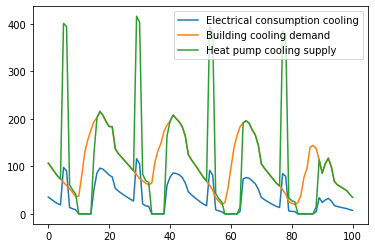

In [5]:
#Plots for the last 100 hours of the simulation
plt.plot(env.buildings[0].cooling_device.electrical_consumption_cooling[2400:])
plt.plot(env.buildings[0].sim_results['cooling_demand'][3500:6000].values[2400:])
plt.plot(env.buildings[0].cooling_device.cooling_supply[2400:])
plt.legend(['Electrical consumption cooling','Building cooling demand','Heat pump cooling supply'])

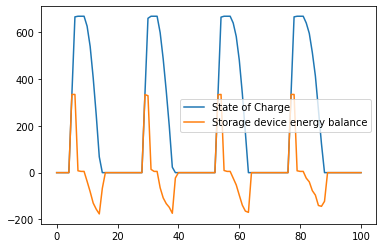

In [6]:
#Plots for the last 100 hours of the simulation
plt.plot(env.buildings[0].cooling_storage.soc_list[2400:])
plt.plot(env.buildings[0].cooling_storage.energy_balance_list[2400:])
plt.legend(['State of Charge','Storage device energy balance'])

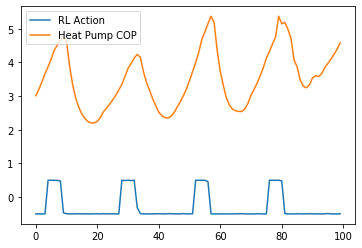

In [7]:
#Plots for the last 100 hours of the simulation
plt.plot(env.action_track[4][5000+2400:5000+2500])
plt.plot(env.buildings[0].cooling_device.cop_cooling_list[2400:2500])
plt.legend(['RL Action','Heat Pump COP'])

As the previous figure shows, the RL agent learns to store additional cooling energy when the coefficient of performance (COP) of the heat pump is higher and release it when it is lower. This helps reduce the overall energy consumption of the building.